In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt


df = pd.read_csv('/home/endershade/Desktop/Python_Course_Repo/lesson_22_tue_29_apr/house_price_analysis/kc_house_data.csv')

# Conversione data in datetime
df['date'] = df['date'].str.replace('T000000', '', regex=False)

df["date"] = pd.to_datetime(df["date"], format="%Y%m%d")
df["date"].head()

# Sostituzione dei valori di yr_renovated
df['yr_renovated'] = pd.cut(df['yr_renovated'], bins=[-1, 0, 1980, 2000, float('inf')], labels=[0, 1, 2, 3])

# Visualizza le prime righe per verificare la sostituzione
df['yr_renovated'].head()

X = df.drop(columns=["price", "date", "id"]) #, "lat", "long", "zipcode"
y = df["price"]

scaler = StandardScaler()   
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\fabri\\Desktop\\MarcoPatierno_DepositoCorsoPython\\env\\Giorno 19 29-04\\esercitazione_house\\kc_house_data.csv'

In [ ]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


def elimina_variabili_vif_pvalue(X_train, y_train,
                                 vif_threshold=10.0,
                                 pvalue_threshold=0.05):
    # Se non è già un DataFrame, lo trasformo
    if not isinstance(X_train, pd.DataFrame):
        X_current = pd.DataFrame(
            X_train,
            columns=[f"x{i}" for i in range(X_train.shape[1])]
        )
    else:
        X_current = X_train.copy()

    while True:
        # Aggiungo costante (ora X_current è DataFrame)
        X_const = sm.add_constant(X_current)
        model   = sm.OLS(y_train, X_const).fit()

        # Prendo i p-value come Series e tolgo la costante
        pvalues = pd.Series(model.pvalues, index=X_const.columns)
        pvalues = pvalues.drop('const')

        # Calcolo il VIF
        vif = pd.DataFrame({
            "Feature": X_current.columns,
            "VIF": [
                variance_inflation_factor(X_current.values, i)
                for i in range(X_current.shape[1])
            ]
        })

        # Unisco VIF e p-value
        stats = vif.copy()
        stats["p-value"] = pvalues.values

        # Seleziono candidati con VIF e p-value alti
        candidates = stats[
            (stats["VIF"] > vif_threshold) &
            (stats["p-value"] > pvalue_threshold)
        ]
        if candidates.empty:
            print("\nNessuna variabile da eliminare. Selezione completata.")
            break

        # Rimuovo la feature peggiore
        worst = candidates.sort_values(by="VIF", ascending=False).iloc[0]
        feat = worst["Feature"]
        print(f"Rimuovo '{feat}' (VIF={worst['VIF']:.2f}, p-value={worst['p-value']:.4f})")

        X_current = X_current.drop(columns=[feat])

    print("\nFeature finali selezionate:")
    print(X_current.columns.tolist())
    return X_current


In [ ]:
X_current = elimina_variabili_vif_pvalue(X_train, y_train, vif_threshold=10.0, pvalue_threshold=0.05)

c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)



Nessuna variabile da eliminare. Selezione completata.

Feature finali selezionate:
['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17']


RMSE: 0.58
R^2: 0.70


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


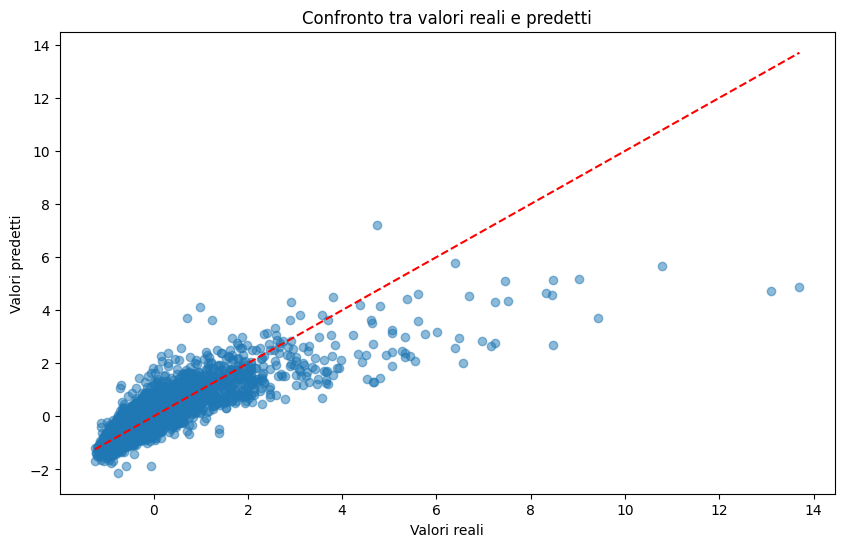

In [ ]:
model = LinearRegression()
model.fit(X_current, y_train)
y_pred = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R^2: {r2:.2f}")
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Valori reali")
plt.ylabel("Valori predetti")
plt.title("Confronto tra valori reali e predetti")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()

In [ ]:
from sklearn.linear_model import LassoCV, Lasso, RidgeCV, Ridge, ElasticNetCV, ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt


lasso_cv    = LassoCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0], cv=5, random_state=0)
ridge_cv    = RidgeCV(alphas=[0.1, 0.5, 1.0, 5.0, 10.0], cv=5)
elastic_cv  = ElasticNetCV(
    alphas=[0.1, 0.5, 1.0, 5.0, 10.0],
    l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0],
    cv=5,
    random_state=0
)

# Fit sui dati filtrati dal VIF
lasso_cv.fit(X_current, y_train)
ridge_cv.fit(X_current, y_train)
elastic_cv.fit(X_current, y_train)

print(f"Best alpha per Lasso:      {lasso_cv.alpha_:.4f}")
print(f"Best alpha per Ridge:      {ridge_cv.alpha_:.4f}")
print(f"Best alpha per ElasticNet: {elastic_cv.alpha_:.4f}")
print(f"Best l1_ratio (ElasticNet):{elastic_cv.l1_ratio_:.4f}")

# --- 2) Addestra i modelli definitivi con i parametri scelti --- #
lasso   = Lasso(alpha=lasso_cv.alpha_, random_state=0)
ridge   = Ridge(alpha=ridge_cv.alpha_)
elastic = ElasticNet(alpha=elastic_cv.alpha_, l1_ratio=elastic_cv.l1_ratio_, random_state=0)

lasso.fit(X_current, y_train)
ridge.fit(X_current, y_train)
elastic.fit(X_current, y_train)

# --- 3) Predizione sul set di test filtrato --- #
y_pred_lasso   = lasso.predict(X_test)
y_pred_ridge   = ridge.predict(X_test)
y_pred_elastic = elastic.predict(X_test)

# --- 4) Metriche di valutazione --- #
r2_lasso    = r2_score(y_test, y_pred_lasso)
r2_ridge    = r2_score(y_test, y_pred_ridge)
r2_elastic  = r2_score(y_test, y_pred_elastic)

rmse_lasso    = sqrt(mean_squared_error(y_test, y_pred_lasso))
rmse_ridge    = sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_elastic  = sqrt(mean_squared_error(y_test, y_pred_elastic))

print("\nConfronto modelli su test set:")
print("=" * 40)
print(f"Lasso     → R²: {r2_lasso:.4f}, RMSE: {rmse_lasso:.4f}")
print(f"Ridge     → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")
print(f"ElasticNet→ R²: {r2_elastic:.4f}, RMSE: {rmse_elastic:.4f}")


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1664: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha per Lasso:      0.1000
Best alpha per Ridge:      10.0000
Best alpha per ElasticNet: 0.1000
Best l1_ratio (ElasticNet):0.1000

Confronto modelli su test set:
Lasso     → R²: 0.6301, RMSE: 0.6441
Ridge     → R²: 0.7018, RMSE: 0.5783
ElasticNet→ R²: 0.6911, RMSE: 0.5886


c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Lasso was fitted with feature names
  warnings.warn(
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
c:\Users\fabri\Desktop\MarcoPatierno_DepositoCorsoPython\env\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but ElasticNet was fitted with feature names
  warnings.warn(


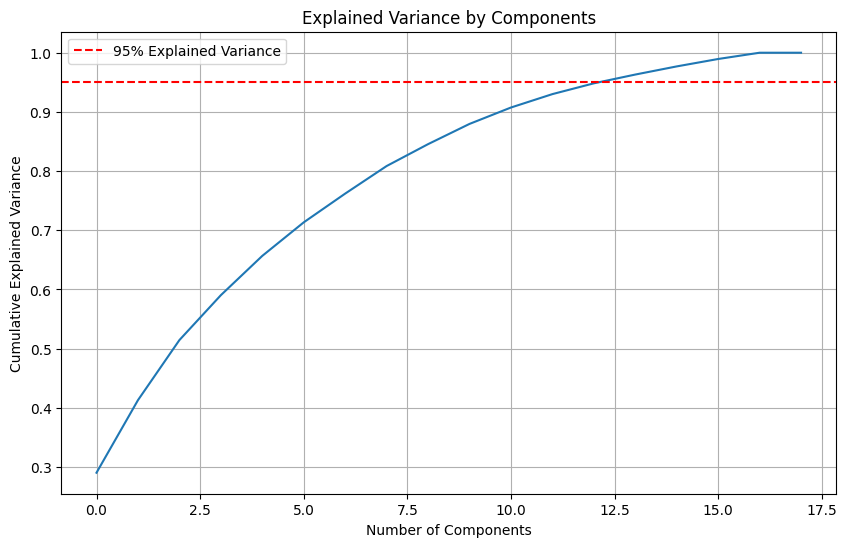

Number of components needed for 95% variance: 14
PCA Model → R²: 0.6971, RMSE: 0.5828
Ridge Model → R²: 0.7018, RMSE: 0.5783


In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Create PCA object and fit to training data
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

# Plot explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Explained Variance')
plt.legend()
plt.show()

# Select number of components that explain 95% of variance
n_components = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components}")

# Create PCA with optimal components
pca_optimal = PCA(n_components=n_components)
X_train_pca_optimal = pca_optimal.fit_transform(X_train)
X_test_pca_optimal = pca_optimal.transform(X_test)

# Train and evaluate model with PCA
model_pca = LinearRegression()
model_pca.fit(X_train_pca_optimal, y_train)
y_pred_pca = model_pca.predict(X_test_pca_optimal)

# Evaluate PCA model
rmse_pca = sqrt(mean_squared_error(y_test, y_pred_pca))
r2_pca = r2_score(y_test, y_pred_pca)
print(f"PCA Model → R²: {r2_pca:.4f}, RMSE: {rmse_pca:.4f}")

# Compare with best previous model (Ridge)
print(f"Ridge Model → R²: {r2_ridge:.4f}, RMSE: {rmse_ridge:.4f}")